# Alternative packages for plotting clustergrams
Testing several alternatives to seaborn.clustermap to plot drug toxicity profiles. 
Seaborn was chosen for ease of use and aesthetics


In [6]:
# Alternative clustergrams of cell painting data in myoblasts vs myotubes
# Author : Roman Lambert
# 31/03/2023 start ->

## Harmony & CellProfiler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dash_bio as db
from toxifate import *
import pycytominer as pcm
import seaborn as sns
from matplotlib.colors import ListedColormap
from pathlib import Path


path = r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\Harmony\Nv6-PerWell\tubesProfiles.csv"
# path = r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\Harmony\Nv6-PerWell\blastsProfiles.csv"
# path = r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\CellProfiler\PerWell\tubesPolyByWellProfiler.csv"
# path = r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\CellProfiler\PerWell\tubesMonoByWellProfiler.csv"
# path = r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\CellProfiler\PerWell\blastsAllByWellProfiler.csv"

# path = r"D:\OneDrive - National University of Ireland, Galway\CellPainting project data\Harmony\Nv6-PerWell\blastsProfiles.csv"

# fileName = path.rsplit('\\')[-1].rsplit('.')[0]

HA_tubes_well = pd.read_csv(path).dropna(axis=1)
HA_tubes_well = consistent_file_format(HA_tubes_well)

HA_tubes_well = HA_tubes_well.loc[HA_tubes_well["Count"] > 50]

HA_tubes_well.drop(["Unnamed: 0"], axis=1, inplace=True, errors="ignore")
HA_tubes_well.drop(
    columns=[
        "Unnamed: 0",
        "Object No in All cells no border",
        "Count",
        "Row",
        "Column",
        "Metadata_Well",
    ],
    inplace=True,
    errors="ignore",
)

HA_tubes_well.replace([np.inf, -np.inf], np.nan, inplace=True)
HA_tubes_well.dropna(axis=1, inplace=True)

print(str(HA_tubes_well.shape[1]) + " features remaining")

930 features remaining


In [7]:
HA_tubes_well_normalized = pd.DataFrame()

meta_features = ["Compound", "Concentration", "PlateName"]
features = (HA_tubes_well.columns.difference(meta_features)).to_list()


for plate in enumerate(HA_tubes_well["PlateName"].unique()):
    temp_df = pcm.normalize(
        profiles=HA_tubes_well.loc[HA_tubes_well["PlateName"] == plate[1]],
        features=features,
        meta_features=meta_features,
        method="mad_robustize",
        mad_robustize_epsilon=0,
        samples="Compound =='DMSO'",
    )

    HA_tubes_well_normalized = pd.concat([HA_tubes_well_normalized, temp_df], axis=0)

### Replace Infinite values with NaN (should be mitigated by mad epsilon = 0)
HA_tubes_well.set_index(["Compound", "Concentration", "PlateName"], inplace=True)
HA_tubes_well_normalized.set_index(
    ["Compound", "Concentration", "PlateName"], inplace=True
)
HA_tubes_well_normalized.reset_index(inplace=True)

In [8]:
# HA_tubes_well_normalized.to_csv(r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\Harmony\Nv6-PerWell\tubesProfilesNormalized.csv", index=False)

# drop features with high and low var + correlated columns
HA_tubes_well_normalized = drop_high_variance(HA_tubes_well_normalized, 10)
HA_tubes_well_normalized = drop_low_variance(HA_tubes_well_normalized, 2)
HA_tubes_well_normalized = drop_correlated_columns(HA_tubes_well_normalized, 0.9, True)
print(str(HA_tubes_well_normalized.shape[1]) + " features remaining")

High variance filter : 38 features dropped (4.086%)
Low variance filter : 54 features dropped (6.054%)
Correlation filter : 588 features dropped (70% of total)
250 features remaining


In [16]:
# run PCA of HA_tubes_well and import PCA
from sklearn.decomposition import PCA
import plotly.express as px


HA_tubes_well_stripped = (
    HA_tubes_well_normalized.drop(columns=["Compound", "Concentration", "PlateName"])
    .clip(-10, 10)
    .dropna(axis=1)
)

pca = PCA(n_components=0.9, svd_solver="auto")
HA_tubes_well_pca = pca.fit_transform(HA_tubes_well_stripped)
HA_tubes_well_pca = pd.DataFrame(HA_tubes_well_pca)
HA_tubes_well_pca["Compound"] = HA_tubes_well_normalized["Compound"]
HA_tubes_well_pca["Concentration"] = HA_tubes_well_normalized["Concentration"].astype(
    str
)
HA_tubes_well_pca["PlateName"] = HA_tubes_well_normalized["PlateName"]
HA_tubes_well_pca["Replicate"] = (
    HA_tubes_well_normalized["PlateName"].str.split("-").str[1]
)

grouped_pca = HA_tubes_well_pca.groupby(
    by=["Compound", "Concentration", "PlateName", "Replicate"]
).median(numeric_only=True)
grouped_pca.reset_index(inplace=True)
# plot scatter of PC1, PC2 and PC3 with px, reduce marker size to 0.5
# fig = px.scatter(grouped_pca, x='PC1', y='PC2', color='Compound', opacity=1, size_max=2, width=1000, height=1000, hover_data=['Compound','Concentration','PlateName'])
# fig.show()
print(str(grouped_pca.shape[1]) + " features included in PCA")
pd.Series(pca.explained_variance_ratio_).head(8)

42 features included in PCA


0    0.351879
1    0.122008
2    0.067582
3    0.055136
4    0.047896
5    0.033086
6    0.027004
7    0.020236
dtype: float64

In [10]:
# create a heatmap of HA_tubes_well where compound = DEXA
chips = HA_tubes_well_normalized.copy()


chips = chips.loc[  # (HA_tubes_well_normalized['Compound'].isin(
    #      ['COLC','DEXA','ATOR','ETOP','SIMV',
    #       'FIAL','NELA','SUNI','SELU','ETRE',
    #       'GEMF','ZIDO','IMAT','LEFL','CLOF',
    #       'CLEV','WURS'])) &
    (HA_tubes_well_normalized["Concentration"].isin([1000, 3000, 10000, 30000]))
    # & (HA_tubes_well_normalized['PlateName'].str.contains('tubes5'))
]

chips["Perturbation"] = chips["Compound"] + " " + chips["Concentration"].astype(str)
chips.sort_values(by=["Compound", "Concentration", "PlateName"], inplace=True)
chips.set_index("Perturbation", inplace=True)

chips.replace([np.inf, -np.inf], np.nan, inplace=True)
chips.dropna(axis=1, inplace=True)

# Map a RGB color to chips['PlateName']
colors = ListedColormap(
    [
        "red",
        "green",
        "blue",
        "yellow",
        "orange",
        "purple",
        "black",
        "white",
        "grey",
        "pink",
    ]
)
color_mapping = pd.factorize(chips["PlateName"])[0]
rgb_colors = colors(color_mapping)

# Drop columns and plot the clustermap
# chips.drop(columns=['Compound','Concentration','PlateName'], inplace=True)

chips = chips.groupby(by=["Compound", "Concentration"]).median(numeric_only=True)

chips = chips.clip(lower=-5.0, upper=5.0, axis=0)
chips = chips.round(2)
chips.dropna(how="any", inplace=True)


# flatten index
chips.reset_index(inplace=True)
chips["Perturbation"] = chips["Compound"] + "-" + chips["Concentration"].astype(str)
chips.set_index("Perturbation", inplace=True)
chips.drop(columns=["Compound", "Concentration"], inplace=True)

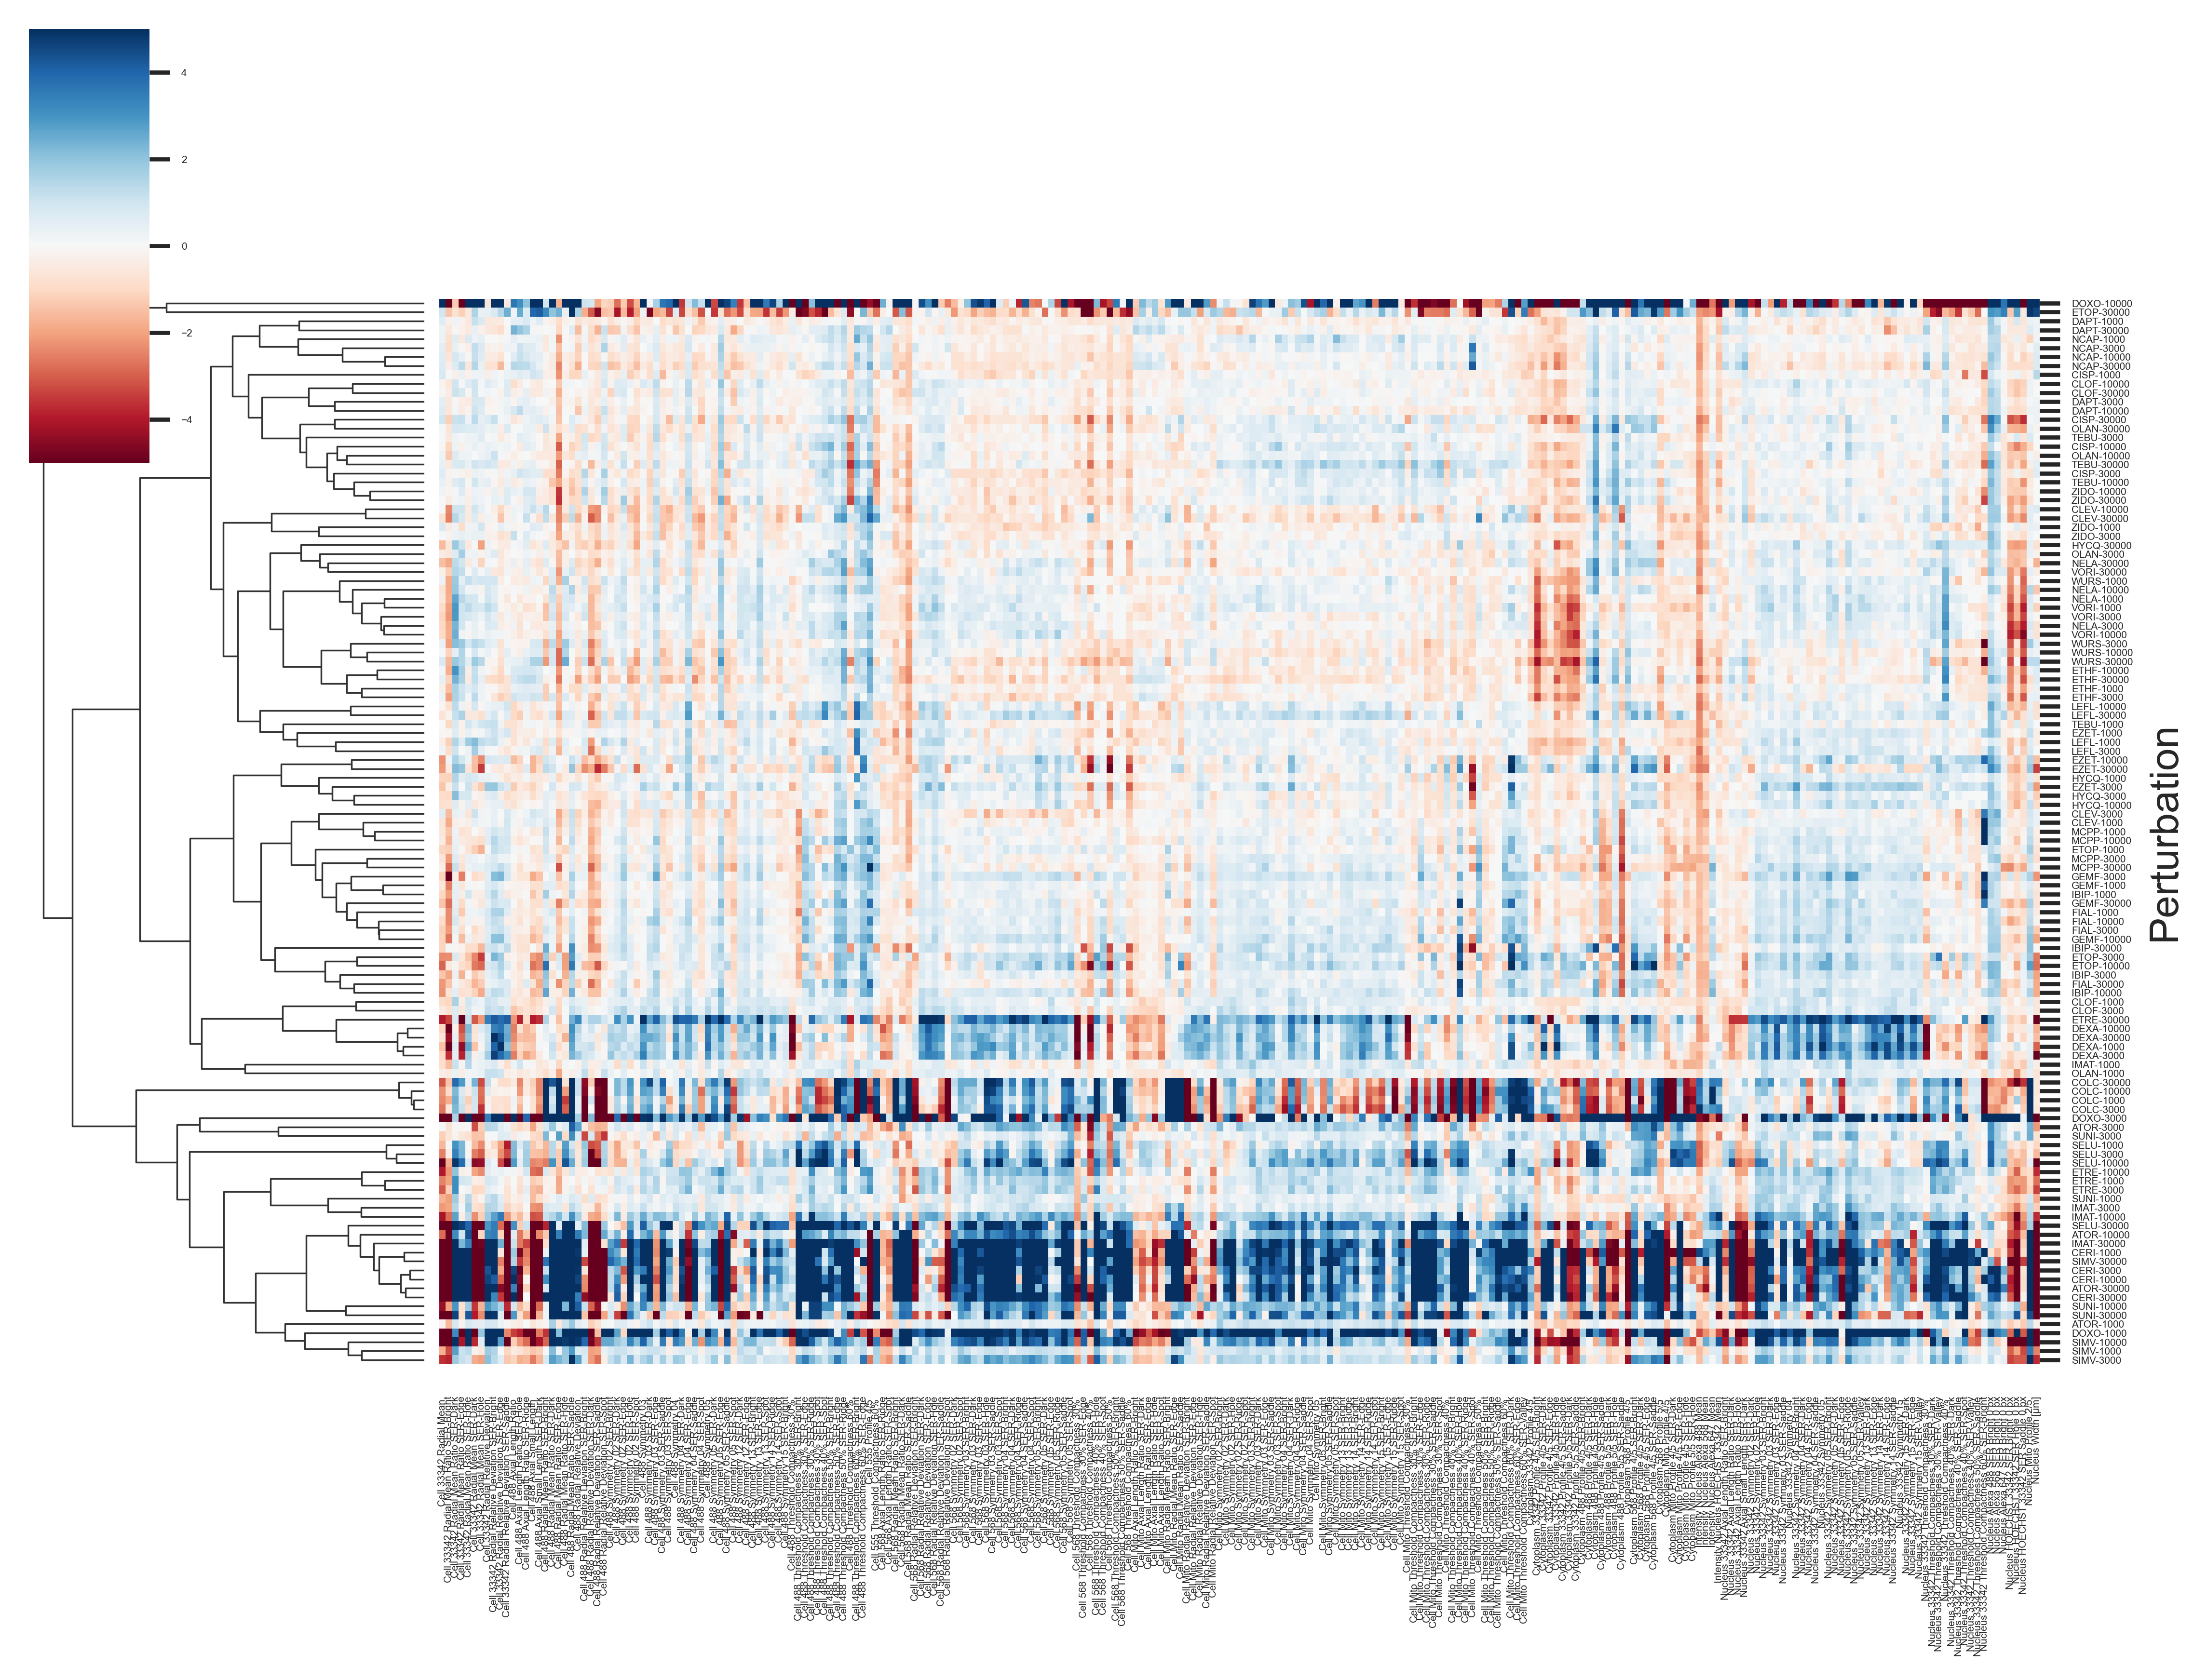

In [11]:
sns.set_theme(rc={"figure.dpi": 500})
fig = sns.clustermap(
    data=chips,
    cmap="RdBu",
    col_cluster=False,
    row_cluster=True,
    metric="correlation",
    center=0,
    z_score=None,
    # row_colors=rgb_colors,
    xticklabels=True,
    yticklabels=True,
    method="average",
    vmin=-5.00,
    vmax=5.00,
)
fig.tick_params(axis="x", which="both", labelsize=3)
fig.tick_params(axis="y", which="both", labelsize=3)
plt.show()

In [12]:
# heatmap with plotly
import plotly.express as px
import plotly.figure_factory as ff

heatmap = px.imshow(
    chips,
    x=chips.columns,
    y=chips.index,
    aspect="auto",
    width=800,
    height=1000,
    color_continuous_scale=px.colors.diverging.RdBu,
)

heatmap.update_layout(
    title="Heatmap of HA_tubes_well",
    xaxis_title="Feature",
    yaxis_title="Perturbation",
)

heatmap.show()

dendro = ff.create_dendrogram(
    chips, color_threshold=15, labels=chips.index, orientation="right"
)
dendro.update_layout(width=400, height=800)
dendro.show()

In [13]:
import pandas as pd
import dash_bio as dashbio

dashbio.Clustergram(
    data=chips,
    row_labels=chips.index.tolist(),
    column_labels=chips.columns.tolist(),
    hidden_labels="column",
    cluster="row",
    row_dist="correlation",
    color_threshold={"row": 10},
    plot_bg_color="#FFFFFF",
    height=1000,
    width=1500,
    center_values=0,
    color_map=[[0.0, "#ED2939"], [0.5, "#FFFFFF"], [1.0, "#0018A8"]],
    tick_font=dict(size=8),
    optimal_leaf_order=True,
    link_method="average",
).update_layout(plot_bgcolor="#FFF", paper_bgcolor="#FFF")

median variance for selected compound : 1.273


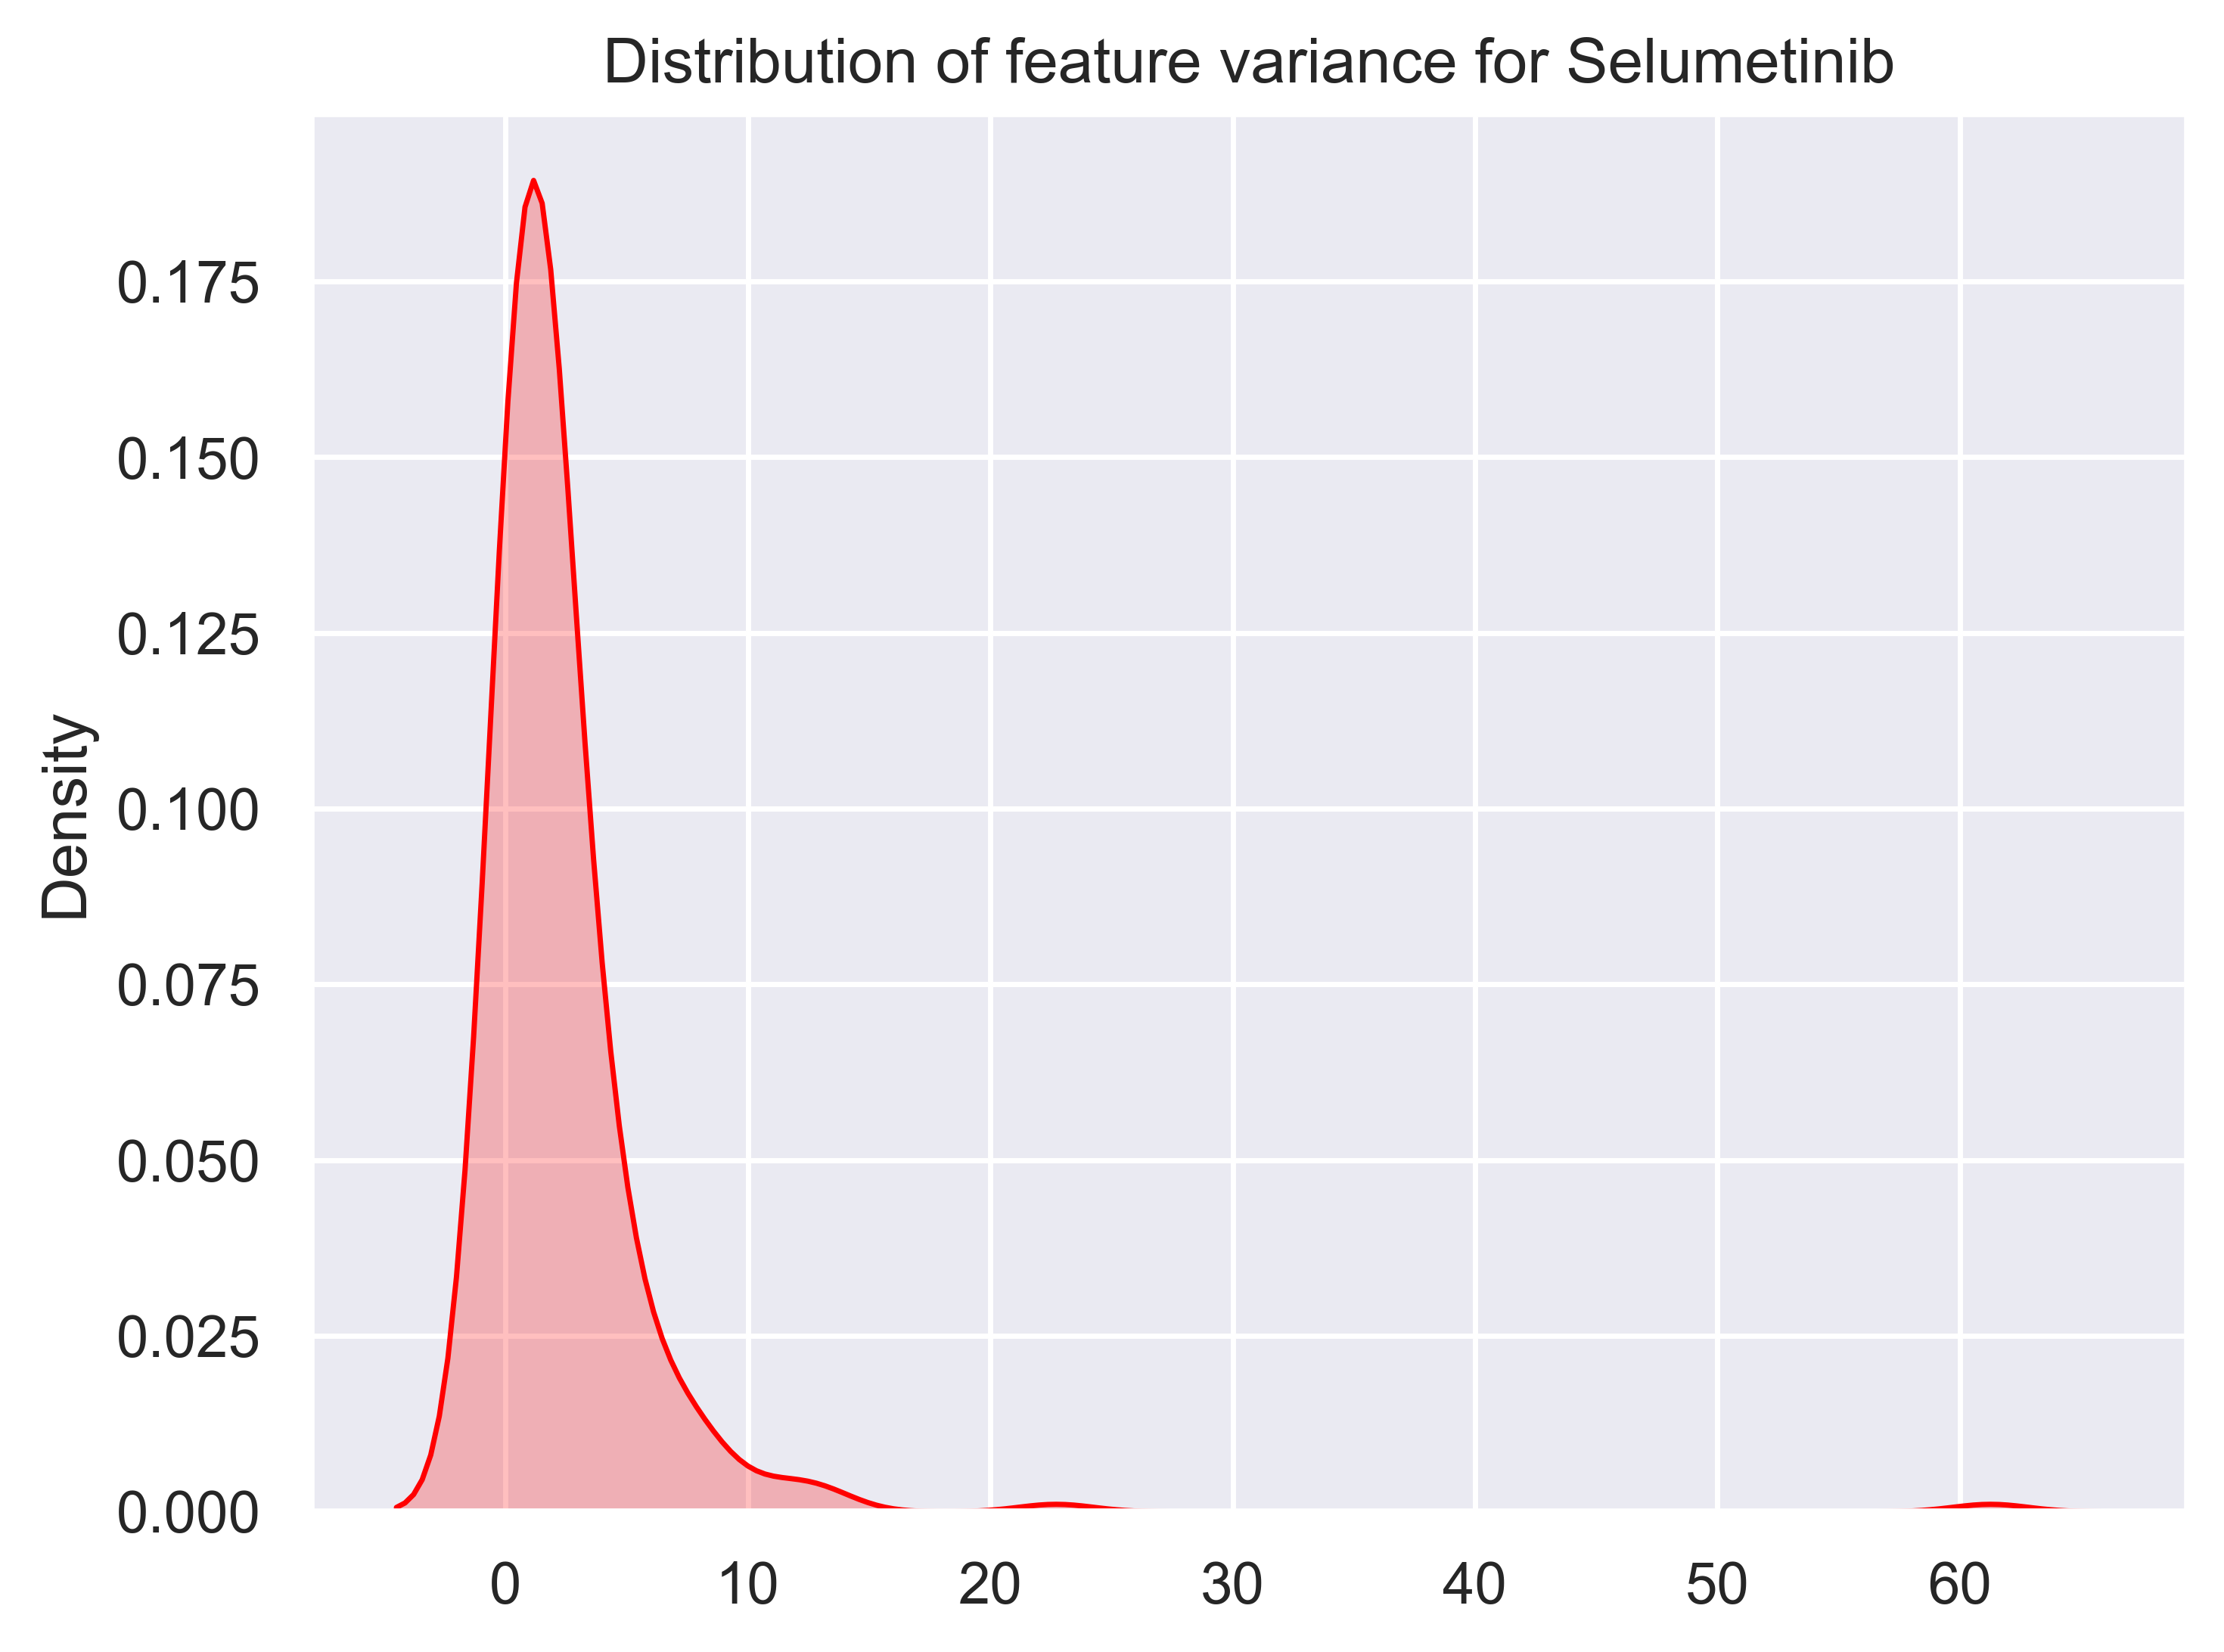

In [14]:
patate = HA_tubes_well_normalized.loc[
    HA_tubes_well_normalized["Compound"].isin(["SELU"])
]
patate = (
    patate.groupby(by=["Compound", "Concentration"]).median(numeric_only=True).round(3)
)
patate.replace([np.inf, -np.inf], np.nan, inplace=True)
patate.dropna(axis=1, inplace=True)

# patate_max = patate.quantile(q= 0.95,axis=0, numeric_only=True)
# patate_min = patate.quantile(q= 0.05, axis=0, numeric_only=True)
patate_max = patate.max(axis=0, numeric_only=True)
patate_min = patate.min(axis=0, numeric_only=True)
patate_diff = patate_max - patate_min

patate_var = patate.var(axis=0, numeric_only=True).sort_values(ascending=False)


variance_plot = sns.kdeplot(data=patate_var, fill=True, color="red")
variance_plot.set_title("Distribution of feature variance for Selumetinib")
print("median variance for selected compound : " + str(np.median(patate_var).round(3)))